In [1]:
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os
from zipfile import ZipFile
from tqdm import tqdm
import shapely
from shapely import MultiPolygon, Polygon, Point
import rasterio
import rasterio.warp
from rasterio import plot, CRS
from collections import Counter, defaultdict
from typing import Dict, List, Tuple, Set
from dacite import from_dict
from dataclasses import dataclass
from abc import ABC
import math
import shutil
from pathlib import Path
import datetime
from shapely.ops import unary_union
import seaborn as sns

from aimlsse_api.data.metar import *

pd.set_option('display.max_colwidth', None)
sns.set_theme()

In [2]:
target_states = ['California', 'Montana', 'Washington', 'Florida', 'Texas']

In [3]:
remove_ambiguous_cloud_cover = False
max_abs_timedelta_minutes = 30.0
station_radius_of_influence = 16000.0 # meters

In [4]:
usa_states: gpd.GeoDataFrame = gpd.read_file('input/us_states_5m.geojson')
usa_states.set_index('NAME', inplace=True)

In [5]:
data_dir = 'data'
state_dirs = pd.DataFrame(pd.Series(target_states, name='state'))
state_dirs['target']    = state_dirs['state'].apply(lambda state: os.path.join(data_dir, 'queries', state))
state_dirs['features']  = state_dirs['target'].apply(lambda target_dir: os.path.join(target_dir, 'features'))
state_dirs['preprocessing']  = state_dirs['target'].apply(lambda target_dir: os.path.join(target_dir, 'preprocessing'))
state_dirs.set_index('state', inplace=True)
for dir in state_dirs['features'].to_list() + state_dirs['preprocessing'].to_list():
    os.makedirs(dir, exist_ok=True)

In [6]:
state_dirs

,target,features,preprocessing
state,,,
California,data\queries\California,data\queries\California\features,data\queries\California\preprocessing
Montana,data\queries\Montana,data\queries\Montana\features,data\queries\Montana\preprocessing
Washington,data\queries\Washington,data\queries\Washington\features,data\queries\Washington\preprocessing
Florida,data\queries\Florida,data\queries\Florida\features,data\queries\Florida\preprocessing
Texas,data\queries\Texas,data\queries\Texas\features,data\queries\Texas\preprocessing


In [7]:
cloud_covers_order = ['CLR', 'FEW', 'SCT', 'BKN', 'OVC']

In [8]:
product_files: Dict[str, List[str]] = {state: os.listdir(data['features']) for state, data in state_dirs.iterrows()}
print(f'Found {sum([len(products) for products in product_files.values()])} products in total')
print({state: len(products) for state, products in product_files.items()})

Found 6629 products in total
{'California': 1371, 'Montana': 743, 'Washington': 965, 'Florida': 795, 'Texas': 2755}


In [9]:
products_per_state: Dict[str, List[str]] = {}
for state in target_states:
    features_dir = state_dirs.loc[state, 'features']
    print(features_dir)
    for file in tqdm(list(filter(lambda x: x.endswith('.zip'), product_files[state]))):
        filepath = os.path.join(features_dir, file)
        with ZipFile(filepath) as zip_file:
            zip_file.extractall(features_dir)
        os.remove(filepath)
    local_products: List[str] = os.listdir(features_dir)
    print(f'Found {len(local_products)} products for {state}')
    products_per_state[state] = local_products
all_products = [product for state in target_states for product in products_per_state[state]]
print(f'Found {len(all_products)} products in total')

data\queries\California\features


0it [00:00, ?it/s]


Found 1371 products for California
data\queries\Montana\features


0it [00:00, ?it/s]


Found 743 products for Montana
data\queries\Washington\features


0it [00:00, ?it/s]


Found 965 products for Washington
data\queries\Florida\features


0it [00:00, ?it/s]


Found 795 products for Florida
data\queries\Texas\features


0it [00:00, ?it/s]

Found 2755 products for Texas
Found 6629 products in total


In [10]:
def add_state_to_dataframe(data:pd.DataFrame, state:str):
    data['state'] = state
    return data

sentinel_products_metadata: pd.DataFrame = pd.concat([
    add_state_to_dataframe(pd.read_csv(os.path.join(row['preprocessing'], 'sentinel_products_metadata.csv'), index_col=0), state) for state, row in state_dirs.iterrows()
])
date_columns = ['beginposition', 'endposition', 'generationdate', 'ingestiondate']
for col in date_columns:
    sentinel_products_metadata[col] = pd.to_datetime(sentinel_products_metadata[col], unit='ms', utc=True)
print(f'Found metadata for {sentinel_products_metadata.shape[0]} sentinel products')
sentinel_products_metadata = sentinel_products_metadata.loc[all_products]
print(f'Reduced to {sentinel_products_metadata.shape[0]} locally available sentinel products')

Found metadata for 15608 sentinel products
Reduced to 6629 locally available sentinel products


Text(0.5, 0, 'cloud cover %')

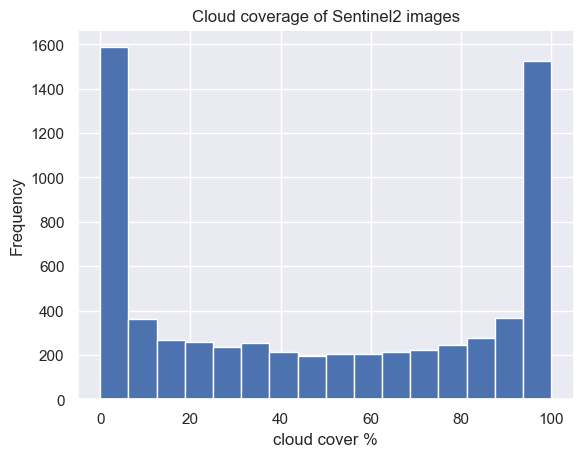

In [11]:
ax: plt.Axes = sentinel_products_metadata.loc[all_products]['cloudcoverpercentage'].plot.hist(bins=16)
ax.set_title('Cloud coverage of Sentinel2 images')
ax.set_xlabel('cloud cover %')

In [12]:
cloud_cover_ranges = {
    'CLR': (-0.001,   6.25),
    'FEW': (6.25,    31.25),
    'SCT': (31.25,   56.25),
    'BKN': (56.25,   93.75),
    'OVC': (93.75,   100.0)
}

sentinel_cc = {}
for cc in cloud_covers_order:
    sentinel_cc[cc] = sentinel_products_metadata[sentinel_products_metadata['cloudcoverpercentage'].apply(lambda x: cloud_cover_ranges[cc][0] < x and x <= cloud_cover_ranges[cc][1])]['uuid'].count()
sentinel_cc

{'CLR': 1587, 'FEW': 1121, 'SCT': 866, 'BKN': 1530, 'OVC': 1525}

<Axes: title={'center': 'Sentinel cloud coverage converted to METAR format'}>

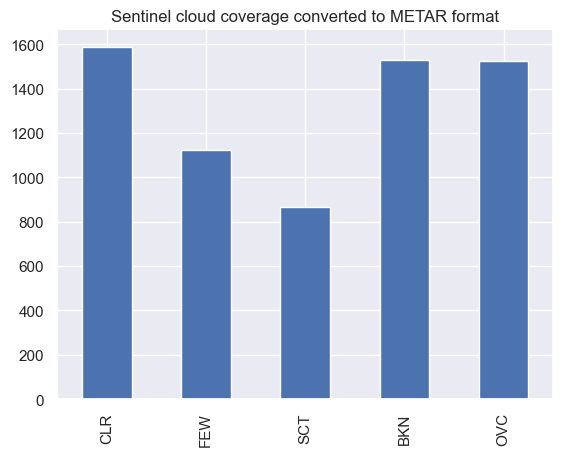

In [13]:
pd.Series(sentinel_cc).plot(kind='bar', title='Sentinel cloud coverage converted to METAR format')

In [14]:
station_metadata = []
for state in target_states:
    tmp_station_metadata = pd.read_csv(os.path.join(state_dirs.loc[state, 'preprocessing'], 'station_metadata.csv'), index_col='id')
    tmp_station_metadata['state'] = state
    station_metadata += [tmp_station_metadata]
station_metadata = pd.concat(station_metadata)
station_metadata.drop(columns=['index_right'], inplace=True)
station_metadata['geometry'] = station_metadata['geometry'].apply(shapely.from_wkt)
station_metadata: gpd.GeoDataFrame = gpd.GeoDataFrame(station_metadata, geometry=station_metadata['geometry'], crs='EPSG:4326')
print(f'Found metadata for {station_metadata.shape[0]} stations')

Found metadata for 15970 stations


In [15]:
station_metadata

,geometry,name,plot_name,network,latitude,longitude,elevation,ISO_A3_EH,country,CONTINENT,distance_to_region,state
id,,,,,,,,,,,,
AZ4299,POINT (-114.46667 32.88333),AZ4299,IMPERIAL DAM,AZCLIMATE,32.88333,-114.46667,52.1208,USA,United States of America,North America,0.0,California
AZ8678,POINT (-114.48333 34.71667),AZ8678,TOPOCK,AZCLIMATE,34.71667,-114.48333,136.8552,USA,United States of America,North America,0.0,California
AZ9662,POINT (-114.61667 32.73333),AZ9662,YUMA WB CITY,AZCLIMATE,32.73333,-114.61667,73.1520,USA,United States of America,North America,0.0,California
AAT,POINT (-120.56444 41.49139),AAT,NaN,CA_ASOS,41.49139,-120.56444,1333.0000,USA,United States of America,North America,0.0,California
ACV,POINT (-124.10861 40.97811),ACV,NaN,CA_ASOS,40.97811,-124.10861,66.0000,USA,United States of America,North America,0.0,California
...,...,...,...,...,...,...,...,...,...,...,...,...
BOQT2,POINT (-102.96230 29.18500),BOQT2,NaN,TX_DCP,29.18500,-102.96230,563.0000,MEX,Mexico,North America,0.0,Texas
CBBT2,POINT (-99.75000 27.70830),CBBT2,NaN,TX_DCP,27.70830,-99.75000,141.0000,MEX,Mexico,North America,0.0,Texas
RGLT2,POINT (-98.56250 26.23750),RGLT2,NaN,TX_DCP,26.23750,-98.56250,40.0000,MEX,Mexico,North America,0.0,Texas


In [16]:
available_stations_in_products = []
for state, products in products_per_state.items():
    for product in products:
        product_dir = os.path.join(state_dirs.loc[state, 'features'], product)
        product_bands = os.listdir(product_dir)
        stations = set()
        for band in product_bands:
            band_dir = os.path.join(product_dir, band)
            stations = stations.union(set([Path(file).stem for file in os.listdir(band_dir)]))
        for station in stations:
            available_stations_in_products += [{'product_id': product, 'station': station}]
available_stations_in_products = pd.DataFrame(available_stations_in_products)

In [17]:
# Load METARs
metars = pd.concat([
    pd.read_json(os.path.join(preprocessing_dir, 'all_metars.json'), orient='table') for preprocessing_dir in state_dirs['preprocessing']
]).reset_index(drop=True)
metars.drop_duplicates(subset=['station', 'datetime', 'product_id'])
metars['datetime'] = pd.to_datetime(metars['datetime'], unit='ms', utc=True)
print(f'Found {metars.shape[0]} METARs for {len(metars.product_id.unique())} products')

# Restrict to available products
keys = list(available_stations_in_products.columns.values)
i1 = metars.set_index(keys).index
i2 = available_stations_in_products.set_index(keys).index
metars = metars[i1.isin(i2)].copy()
# metars = metars[metars['product_id'].isin(all_products)]
print(f'Reduced to {metars.shape[0]} METARs for {len(metars.product_id.unique())} locally available products')

# Convert METAR properties to processable format
metar_property_labels = list(filter(lambda x: x not in ['station', 'datetime', 'product_id'], metars.columns))
metar_properties = [MetarProperty.from_string(label) for label in metar_property_labels]
print('METAR values:', [str(prop) for prop in metar_properties])
metars = MetarPandas.format_dataframe(metars, metar_properties)
print('Formatted METAR values for further processing')

# 1. Derive timedeltas between METAR and satellite image
# 2. Restrict timedelta to the interval of +/- max_abs_timedelta_minutes minutes
metars['timedelta'] = metars.apply(lambda row: row['datetime'].to_numpy() - sentinel_products_metadata.loc[row['product_id']]['beginposition'].to_numpy(), axis=1)
metars['timedelta [minutes]'] = metars['timedelta'].map(lambda x: x.total_seconds() / 60.0)
print(f'Restricted METARs to timedelta +/- {max_abs_timedelta_minutes} [minutes]')
metars = metars[metars['timedelta [minutes]'].abs() <= max_abs_timedelta_minutes]
print(f'Reduced to {metars.shape[0]} METARs')

# Restrict to METARs that have values for the sky-condition property
metars = metars[metars['sky_conditions [M]'].map(lambda x: len(x) > 0)].copy()
print(f'Reduced to {metars.shape[0]} METARs that have provide sky-condition values')

# Format to use multi-index of product-id and station
metars = metars.groupby(['product_id', 'station'], group_keys=True)

# Restrict to METARs that are closest to the observation datetime of their corresponding satellite image
def get_newest_label(data:pd.DataFrame):
    return data.loc[data['timedelta [minutes]'].abs().idxmin()]

metars = metars.apply(lambda x: get_newest_label(x))
print(f'Reduced to {metars.shape[0]} METARs that are closest to the observation datetime of their corresponding satellite image')

Found 27210 METARs for 7281 products
Reduced to 23818 METARs for 6587 locally available products
METAR values: ['temperature [C]', 'current_weather', 'recent_weather', 'sky_conditions [M]', 'metar_code']
Formatted METAR values for further processing
Restricted METARs to timedelta +/- 30.0 [minutes]
Reduced to 23818 METARs
Reduced to 23775 METARs that have provide sky-condition values
Reduced to 12766 METARs that are closest to the observation datetime of their corresponding satellite image


In [18]:
cloud_cover_strength = {
    'CLR': 0,
    'FEW': 1,
    'SCT': 3,
    'BKN': 5,
    'OVC': 8
}

def get_max_cloud_cover(cloud_covers:List[DataSkyConditions]):
    cloud_covers_ranked = [(cloud_cover_strength[cc.cover], cc.cover) if cc.cover in cloud_cover_strength else (-1, cc.cover) for cc in cloud_covers]
    if any(cloud_covers_ranked):
        return max(cloud_covers_ranked)[1]
    else:
        return None

# Derive METAR cloud coverage
metars['cloud cover'] = metars['sky_conditions [M]'].apply(lambda x: [sky.cover for sky in x])

# 1. Derive maximum METAR cloud coverage
# 2. Restrict to METARs that have cloud coverage
metars['max cloud cover'] = metars['sky_conditions [M]'].apply(get_max_cloud_cover)
metars = metars[metars['max cloud cover'].isin(cloud_covers_order)].copy()
print(f'Reduced to {metars.shape[0]} METARs that have cloud coverage in the categories {cloud_covers_order}')

Reduced to 12749 METARs that have cloud coverage in the categories ['CLR', 'FEW', 'SCT', 'BKN', 'OVC']


In [19]:
# Detect ambiguous cloud coverage: overlapping FEW & FEW clouds on different layers could look like SCT from a satellites perspective
tmp = metars['cloud cover'].apply(lambda x: (len(x) == 1) or any([cc == 'OVC' for cc in x]))
ambiguous_cc_metars = metars[~tmp]
true_cc_metars = metars[tmp]
print(f'{ambiguous_cc_metars.shape[0]} of {metars.shape[0]} have ambiguous cloud coverage'
      f'[{ambiguous_cc_metars.shape[0] / metars.shape[0] * 100.0:.1f} %]')

# Restrict to unambiguous cloud cover
if remove_ambiguous_cloud_cover:
    metars = true_cc_metars.copy()
    print(f'Reduced to {metars.shape[0]} METARs with unambiguous cloud cover')

1870 of 12749 have ambiguous cloud coverage[14.7 %]


<Axes: title={'center': 'Ambiguous cloud cover'}>

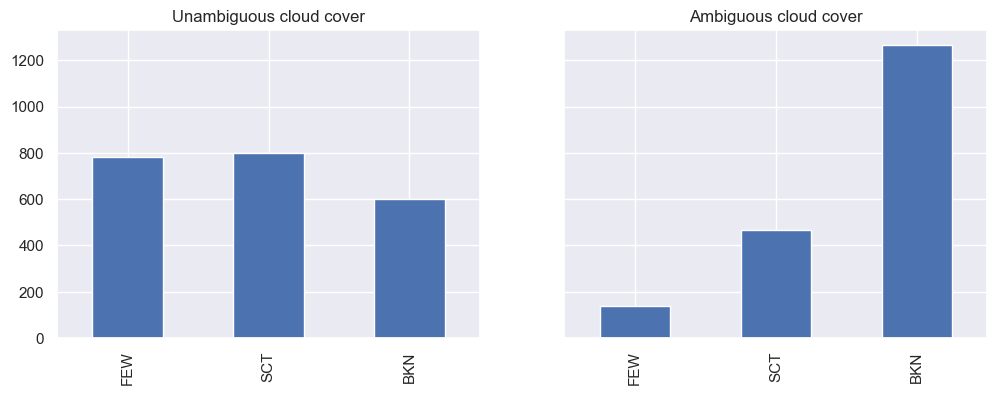

In [20]:
fig, axs = plt.subplots(figsize=(12,4), ncols=2, sharey=True)

true_cc_metars_ctr = dict(Counter(true_cc_metars['max cloud cover']))
for cc in cloud_covers_order:
    if cc not in true_cc_metars_ctr:
        true_cc_metars_ctr[cc] = 0
pd.Series(true_cc_metars_ctr).loc[['FEW', 'SCT', 'BKN']].plot.bar(ax=axs[0], title='Unambiguous cloud cover')

ambiguous_cc_metars_ctr = dict(Counter(ambiguous_cc_metars['max cloud cover']))
for cc in cloud_covers_order:
    if cc not in ambiguous_cc_metars_ctr:
        ambiguous_cc_metars_ctr[cc] = 0
pd.Series(ambiguous_cc_metars_ctr).loc[['FEW', 'SCT', 'BKN']].plot.bar(ax=axs[1], title='Ambiguous cloud cover')

In [21]:
cc_counts = metars.groupby('max cloud cover').count()['station'].loc[cloud_covers_order]
cc_counts

max cloud cover
CLR    5303
FEW     919
SCT    1266
BKN    1867
OVC    3394
Name: station, dtype: int64

Text(0.5, 0, '')

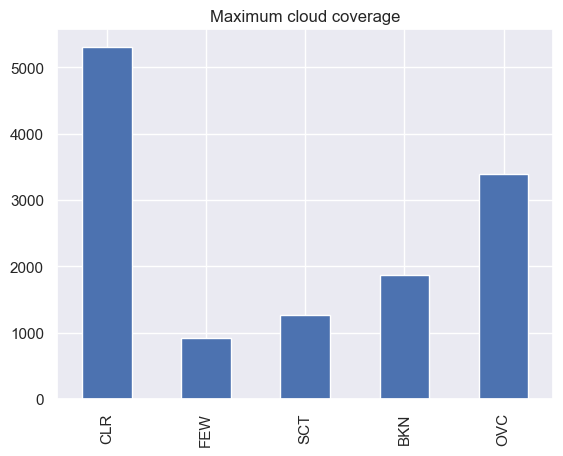

In [22]:
ax = metars.groupby('max cloud cover').count()['station'].loc[cloud_covers_order].plot.bar(title='Maximum cloud coverage')
ax.set_xlabel(None)

In [23]:
metars.groupby('max cloud cover').count()

,station,datetime,temperature [C],current_weather,recent_weather,sky_conditions [M],metar_code,product_id,timedelta,timedelta [minutes],cloud cover
max cloud cover,,,,,,,,,,,
BKN,1867,1867,1864,1867,1867,1867,1867,1867,1867,1867,1867
CLR,5303,5303,5288,5303,5303,5303,5303,5303,5303,5303,5303
FEW,919,919,916,919,919,919,919,919,919,919,919
OVC,3394,3394,3392,3394,3394,3394,3394,3394,3394,3394,3394
SCT,1266,1266,1259,1266,1266,1266,1266,1266,1266,1266,1266


In [24]:
stations = metars['station'].drop_duplicates().to_numpy()
print(f'{len(stations)} stations remain')

325 stations remain


In [25]:
# How many clouds have been detected in the METARs?
clouds = metars['sky_conditions [M]'].apply(lambda skys: [sky.cloud for sky in skys]).to_list()
clouds = pd.Series([item for sublist in clouds for item in sublist])
Counter(clouds)

Counter({None: 17551, 'CB': 21, 'TCU': 11})

Text(0.5, 0, 'time offset in minutes')

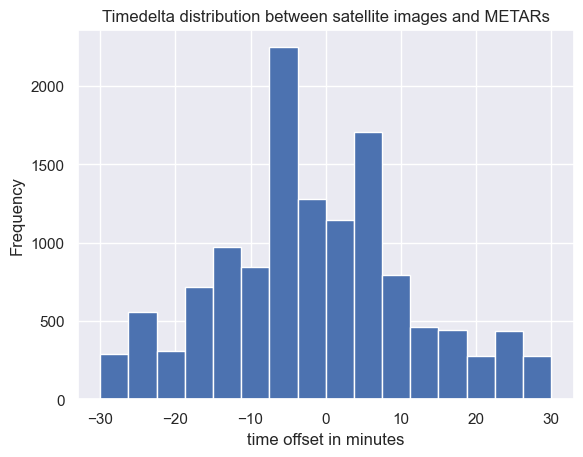

In [26]:
ax: plt.Axes = metars['timedelta [minutes]'].plot.hist(bins=16, title='Timedelta distribution between satellite images and METARs')
ax.set_xlabel('time offset in minutes')

In [27]:
polygons: List[Polygon] = []
for geometry in usa_states.loc[target_states].geometry:
    if isinstance(geometry, MultiPolygon):
        polygons += list(geometry.geoms)
    elif isinstance(geometry, Polygon):
        polygons += [geometry]

<class 'shapely.geometry.multipolygon.MultiPolygon'>


<Axes: >

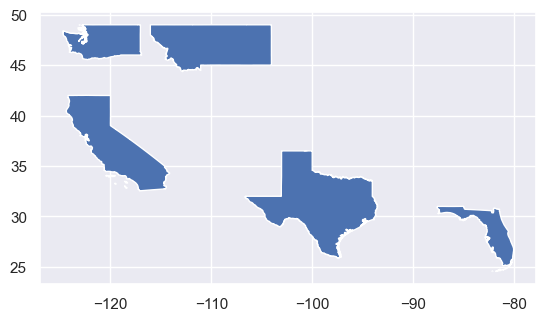

In [28]:
area_of_interest: MultiPolygon = unary_union(polygons)
print(type(area_of_interest))
gpd.GeoSeries(area_of_interest).plot()

In [29]:
def plot_state(ax:plt.Axes, state:str, color:str):
    gpd.GeoSeries(usa_states.loc[state].geometry.buffer(0).boundary).plot(ax=ax, facecolor=color, alpha=1.0, linewidth=0.1, zorder=1)

In [30]:
cloud_covers = pd.DataFrame(metars['sky_conditions [M]'])
cloud_covers['cloud cover'] = cloud_covers['sky_conditions [M]'].apply(lambda sky_conditions: [cond.cover for cond in sky_conditions])
cloud_covers

sky_conditions [M]  \
product_id                           station                                                                                                                                          
00007283-0b01-4764-a8b2-e2379f37028f E38                                                                                  [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9 COF                                                                                  [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     TIX                                                                                  [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     TTS                                                                                  [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     XMR                                                                                  [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
...                                                                                                                                                                             ...   
ffd5bab3-4250-44ef-837f-04e213a66586 GNC                                                                                  [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     LUV                                                                                  [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
ffd7c508-0a7d-4185-9ce8-511fc421d012 ORG                                                                       [DataSkyConditions(cover='SCT', height=3657.5998829568, cloud=None)]   
fff52610-ce95-4c6b-9ebc-5d6912f0ff3d 11R                                                                        [DataSkyConditions(cover='OVC', height=883.9199717146, cloud=None)]   
                                     RWV      [DataSkyConditions(cover='BKN', height=335.279989271, cloud=None), DataSkyConditions(cover='OVC', height=609.5999804928, cloud=None)]   

                                             cloud cover  
product_id                           station              
00007283-0b01-4764-a8b2-e2379f37028f E38           [CLR]  
0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9 COF           [CLR]  
                                     TIX           [CLR]  
                                     TTS           [CLR]  
                                     XMR           [CLR]  
...                                                  ...  
ffd5bab3-4250-44ef-837f-04e213a66586 GNC           [CLR]  
                                     LUV           [CLR]  
ffd7c508-0a7d-4185-9ce8-511fc421d012 ORG           [SCT]  
fff52610-ce95-4c6b-9ebc-5d6912f0ff3d 11R           [OVC]  
                                     RWV      [BKN, OVC]  

[12749 rows x 2 columns]

In [31]:
cloud_covers_flat = [item for sublist in cloud_covers['cloud cover'] for item in sublist]
print(cloud_covers_flat)

['CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'FEW', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'FEW', 'BKN', 'OVC', 'SCT', 'BKN', 'OVC', 'BKN', 'BKN', 'FEW', 'FEW', 'SCT', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'FEW', 'CLR', 'SCT', 'OVC', 'CLR', 'CLR', 'CLR', 'FEW', 'FEW', 'CLR', 'SCT', 'OVC', 'BKN', 'FEW', 'SCT', 'BKN', 'FEW', 'BKN', 'BKN', 'OVC', 'CLR', 'FEW', 'BKN', 'OVC', 'SCT', 'BKN', 'OVC', 'CLR', 'OVC', 'OVC', 'FEW', 'FEW', 'SCT', 'OVC', 'OVC', 'FEW', 'SCT', 'BKN', 'OVC', 'SCT', 'SCT', 'BKN', 'OVC', 'SCT', 'BKN', 'BKN', 'CLR', 'FEW', 'FEW', 'BKN', 'BKN', 'BKN', 'CLR', 'FEW', 'BKN', 'OVC', 'CLR', 'SCT', 'SCT', 'CLR', 'OVC', 'FEW', 'BKN', 'FEW', 'BKN', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'FEW', 'BKN', 'SCT', 'BKN', 'OVC', 'OVC', 'OVC', 'BKN', 'OVC', 'OVC', 'CLR', 'FEW', 'SCT', 'CLR', 'FEW', 'FEW', 'FEW', 'CLR', 'CLR', 'FEW', 'FEW', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'SCT', 'SCT', 'BKN', 'CLR', 'CLR', 'FEW', 'SCT', 'CLR', 'SCT', 'BKN', 'BKN', 'BKN', 'SCT', 'SCT', 'CLR', 'CLR', 'CLR', 'CLR'

<Axes: >

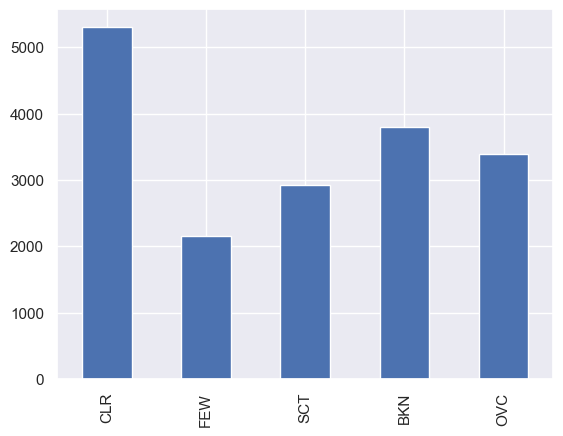

In [32]:
pd.Series(dict(Counter(cloud_covers_flat))).loc[cloud_covers_order].plot(kind='bar')

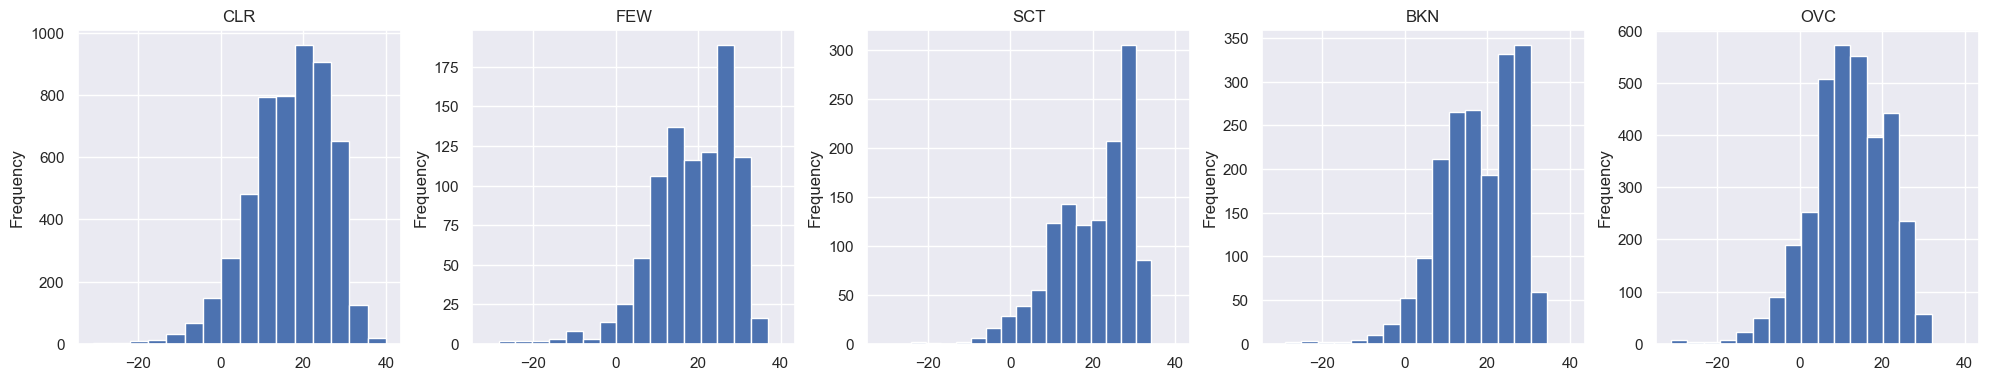

In [33]:
fig, axs = plt.subplots(figsize=(20, 4), ncols=len(cloud_covers_order), sharex=True)
fig.tight_layout(pad=1.6)
for i, cc in enumerate(cloud_covers_order):
    ax: plt.Axes = axs[i]
    ax.set_title(cc)
    metars[metars['max cloud cover'] == cc]['temperature [C]'].plot.hist(ax=ax, bins=16)

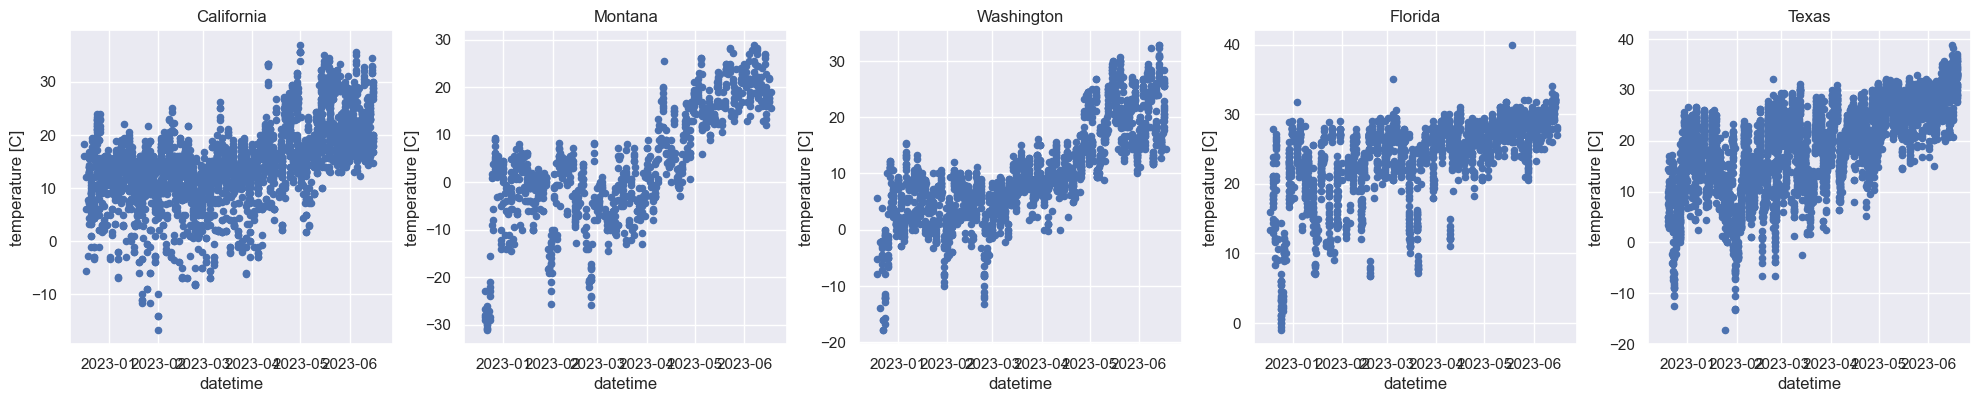

In [34]:
fig, axs = plt.subplots(figsize=(20, 4), ncols=len(target_states), sharex=True)
fig.tight_layout(pad=1.6)
for i, state in enumerate(target_states):
    ax: plt.Axes = axs[i]
    ax.set_title(state)
    local_stations = station_metadata[station_metadata['state'] == state]
    metars[metars['station'].isin(local_stations.index)].plot.scatter(ax=ax, x='datetime', y='temperature [C]')

In [35]:
metars.columns

Index(['station', 'datetime', 'temperature [C]', 'current_weather',
       'recent_weather', 'sky_conditions [M]', 'metar_code', 'product_id',
       'timedelta', 'timedelta [minutes]', 'cloud cover', 'max cloud cover'],
      dtype='object')

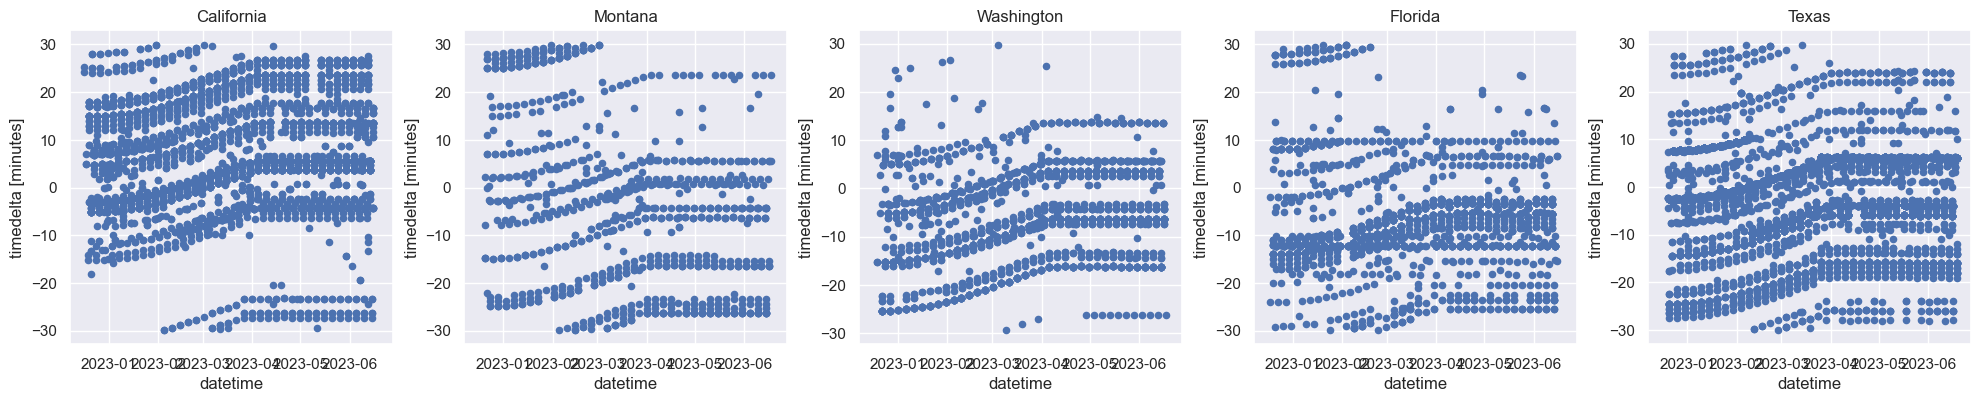

In [36]:
fig, axs = plt.subplots(figsize=(20, 4), ncols=len(target_states), sharex=True)
fig.tight_layout(pad=1.6)
for i, state in enumerate(target_states):
    ax: plt.Axes = axs[i]
    ax.set_title(state)
    local_stations = station_metadata[station_metadata['state'] == state]
    metars[metars['station'].isin(local_stations.index)].plot.scatter(ax=ax, x='datetime', y='timedelta [minutes]')

In [37]:
from numpy import ceil

plot_all_stations = False
if plot_all_stations:
    plot_share_x = True
    plot_layout_scale = 2.0
    plot_layout_columns = 15
    plot_layout_rows = int(ceil(cloud_covers_max_per_station.shape[1] / plot_layout_columns))
    cloud_covers_max_per_station.loc[cloud_covers_order].plot(kind='bar', sharex=plot_share_x, subplots=True, legend=False,
        layout=(plot_layout_rows, plot_layout_columns),
        figsize=(plot_layout_columns * plot_layout_scale, plot_layout_rows * plot_layout_scale))
    if not plot_share_x:
        plt.subplots_adjust(wspace=0.3, hspace=1.0)
    else:
        plt.subplots_adjust(wspace=0.3, hspace=0.4)

In [38]:
metar_station_counts = metars.reset_index(drop=True).groupby(['station'])['product_id'].count().sort_values()

<Axes: ylabel='Frequency'>

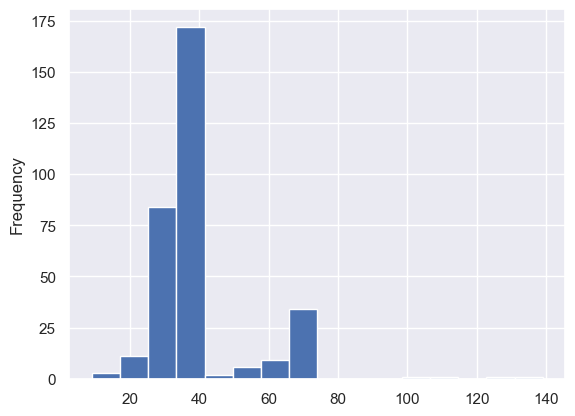

In [39]:
metar_station_counts.plot.hist(bins=16)

In [40]:
station_quantity = metars.reset_index(drop=True).groupby('station')['product_id'].count()
station_quantity

station
11R    24
1GM    23
1KM    54
1S5    67
28J    33
       ..
X26    33
X60    33
XMR    34
YKM    36
ZPH    35
Name: product_id, Length: 325, dtype: int64

Text(0.5, 0, 'Average number of METARS per satellite image')

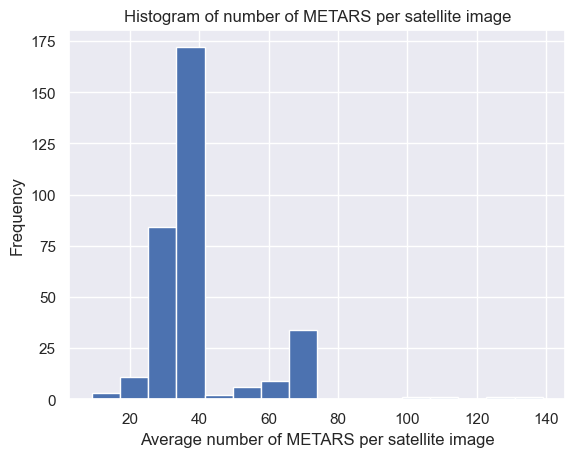

In [41]:
ax: plt.Axes = metars['datetime'].reset_index().groupby('station')['datetime'].count().plot.hist(bins=16, title='Histogram of number of METARS per satellite image')
ax.set_xlabel('Average number of METARS per satellite image')

In [42]:
pd.Series([station_metadata.loc[station, 'state'] for station in metars.reset_index(drop=True)['station']], metars['station'])

station
E38      Texas
COF    Florida
TIX    Florida
TTS    Florida
XMR    Florida
        ...   
GNC      Texas
LUV      Texas
ORG      Texas
11R      Texas
RWV      Texas
Length: 12749, dtype: object

In [43]:
# Add US state name to METARs
station_metadata.loc[metars['station']]['state']

id
E38      Texas
COF    Florida
TIX    Florida
TTS    Florida
XMR    Florida
        ...   
GNC      Texas
LUV      Texas
ORG      Texas
11R      Texas
RWV      Texas
Name: state, Length: 12749, dtype: object

In [44]:
labels = metars.reset_index(drop=True)[['station', 'product_id', 'timedelta [minutes]', 'max cloud cover']].copy()
labels['state'] = labels['station'].apply(lambda x: station_metadata.loc[x, 'state'])
labels

,station,product_id,timedelta [minutes],max cloud cover,state
0,E38,00007283-0b01-4764-a8b2-e2379f37028f,1.816267,CLR,Texas
1,COF,0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9,-11.983733,CLR,Florida
2,TIX,0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9,-19.983733,CLR,Florida
3,TTS,0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9,-11.983733,CLR,Florida
4,XMR,0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9,-11.983733,CLR,Florida
...,...,...,...,...,...
12744,GNC,ffd5bab3-4250-44ef-837f-04e213a66586,-2.017067,CLR,Texas
12745,LUV,ffd5bab3-4250-44ef-837f-04e213a66586,2.982933,CLR,Texas
12746,ORG,ffd7c508-0a7d-4185-9ce8-511fc421d012,4.149600,SCT,Texas
12747,11R,fff52610-ce95-4c6b-9ebc-5d6912f0ff3d,8.316267,OVC,Texas


In [46]:
for state in target_states:
    print(state)
    state_labels = labels[labels['state'] == state].reset_index(drop=True).drop('state', axis=1).copy()
    out_path = os.path.join(state_dirs.loc[state, 'preprocessing'], 'labels.csv')
    if os.path.exists(out_path):
        print('Labels already exits, skipping..')
    else:
        print('Writing labels to file..')
        state_labels.to_csv(out_path)

California
Labels already exits, skipping..
Montana
Labels already exits, skipping..
Washington
Labels already exits, skipping..
Florida
Labels already exits, skipping..
Texas
Writing labels to file..
